In [10]:
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
from scipy.stats import norm
import matplotlib.patches as mpatches
from scipy import signal

##


In [38]:
class simulate_poisson_sequences():
    
    def __init__(self):
        self.plt_laser = []
        self.plt_pulse = []
        self.plt_highbw_transimpndance = []
        self.plt_sync_digitizer = []
        self.plt_unsync_digitizer = []
        self.plt_peaks = []
        self.snr_sync = []
        self.snr_unsync = []
    def run_simulation(self):

        self.line_number = 15
        self.beam_num = 20
        self.sample_f = 60.
        self.time_frame = 30./60.
        scale = 2
        for line in range(self.line_number):

            
    #         sample_f = 1/1e-11
            t_norm = np.arange(0,30./60.*scale,scale/self.sample_f)
            
            t = t_norm
            self.t = t
            self.t_plot = np.arange(0,30./60.*self.beam_num*scale,scale/self.sample_f)

            mat = np.zeros((self.beam_num,len(t)))
            peaks = np.zeros((self.beam_num,len(t)))

            for n in range(self.beam_num):
                for i in range(np.random.poisson(1)):
                    time = np.random.exponential(10./60)
                    diff = abs(t - time)
                    indx = np.where(diff == np.min(diff))[0][0]

                    peaks[n,indx] += 10*np.max(norm.pdf(np.linspace(norm.ppf(0.001),norm.ppf(0.999), 10)))


            self.plt_peaks.append(peaks)
            
            b, a = signal.butter(1, 50./60., 'low', analog=True)
            w, h = signal.freqs(b, a, worN=np.arange(0,self.sample_f,self.sample_f/(mat.size)))

    #         A = 0.7
    #         R = 500
    #         Ci = 0
    #         Cf = 0
    #         s = 1j*np.arange(0,sample_f,sample_f/(mat.size))
    #         w0 = 80e6
    #         Tf = -A*(w0/(s+w0))*R/(s*Ci*R+(1+A*(w0/(s+w0)))*(1+s*Cf*R))


            highbw_transimped_amp = np.real(np.fft.ifft(np.fft.fft(peaks.flatten().copy())*h))

            xmarks=np.array([i for i in range(0,mat.size,len(t))])
            tmp = np.zeros(peaks.size)
            for x in xmarks:
                tmp[x]=np.max(peaks)


            digitizer_sample_highbw= np.zeros(peaks.size)
            digitizer_sample_highbw_unsynced= np.zeros(peaks.size)

            time = 2./60.
            diff = abs(t - time)
            indx = np.where(diff == np.min(diff))[0]


            digitizer_sample_highbw[:int(indx)]=highbw_transimped_amp[0]
            digitizer_sample_highbw_unsynced[:int(indx)]=highbw_transimped_amp[0]

            for i in np.arange(indx,peaks.size,len(t_norm)):
                i = i + indx
                digitizer_sample_highbw[int(i):int(i)+len(t)]=highbw_transimped_amp[int(i)]


            for i in np.arange(0,peaks.size,len(t_norm)):
                i = i + np.random.randint(0,len(t_norm)-1)
                digitizer_sample_highbw_unsynced[int(i):int(i)+len(t)]=highbw_transimped_amp[int(i)]


            self.plt_pulse.append(peaks.flatten())
            self.plt_laser.append(tmp)
            self.plt_sync_digitizer.append(digitizer_sample_highbw)
            self.plt_unsync_digitizer.append(digitizer_sample_highbw_unsynced)
            self.plt_highbw_transimpndance.append(highbw_transimped_amp)
            

        x = np.array(self.plt_sync_digitizer)
        x = np.sum(x.reshape(self.line_number,self.beam_num,len(t)),axis=2) * -1
        x  = (x - np.mean(x))/np.std(x)
        synced_responses = x - np.min(x)


        x = np.array(self.plt_unsync_digitizer)
        x = np.sum(x.reshape(self.line_number,self.beam_num,len(t)),axis=2) * -1
        x  = (x - np.mean(x))/np.std(x)
        unsynced_responses  = x - np.min(x)

        x = np.array(self.plt_pulse)
        x = x
        actual_response = np.sum(x.reshape(self.line_number,self.beam_num,len(t)),axis=2)



        n = len(unsynced_responses.flatten())
        X = unsynced_responses.astype(np.int16).reshape(n,1)

        Y = actual_response.astype(np.int16).flatten()

        A=X.T.dot(X)
        b=X.T.dot(Y)
        z = np.linalg.solve(A,b)
        errors_unsync = Y-X.dot(z)

        n = len(synced_responses.flatten())
        X = synced_responses.astype(np.int16).reshape(n,1)

        Y = actual_response.astype(np.int16).flatten()

        A=X.T.dot(X)
        b=X.T.dot(Y)
        z = np.linalg.solve(A,b)
        errors_sync = Y-X.dot(z)

        self.snr_sync.append(np.var(actual_response)/np.var(errors_sync))
        self.snr_unsync.append(np.var(actual_response)/np.var(errors_unsync))

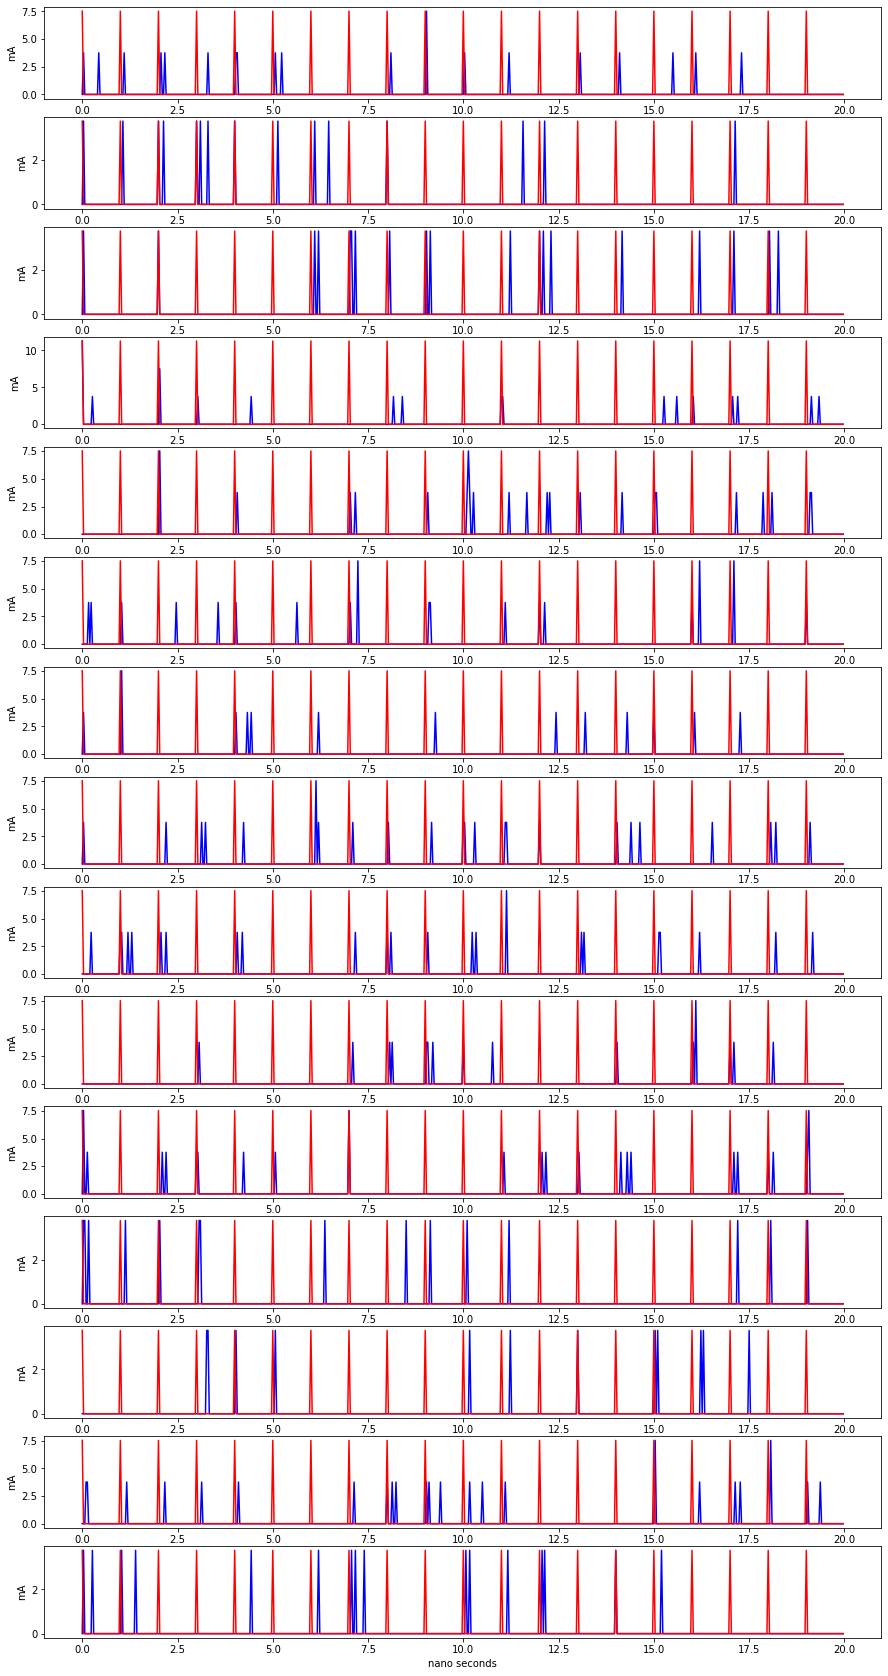

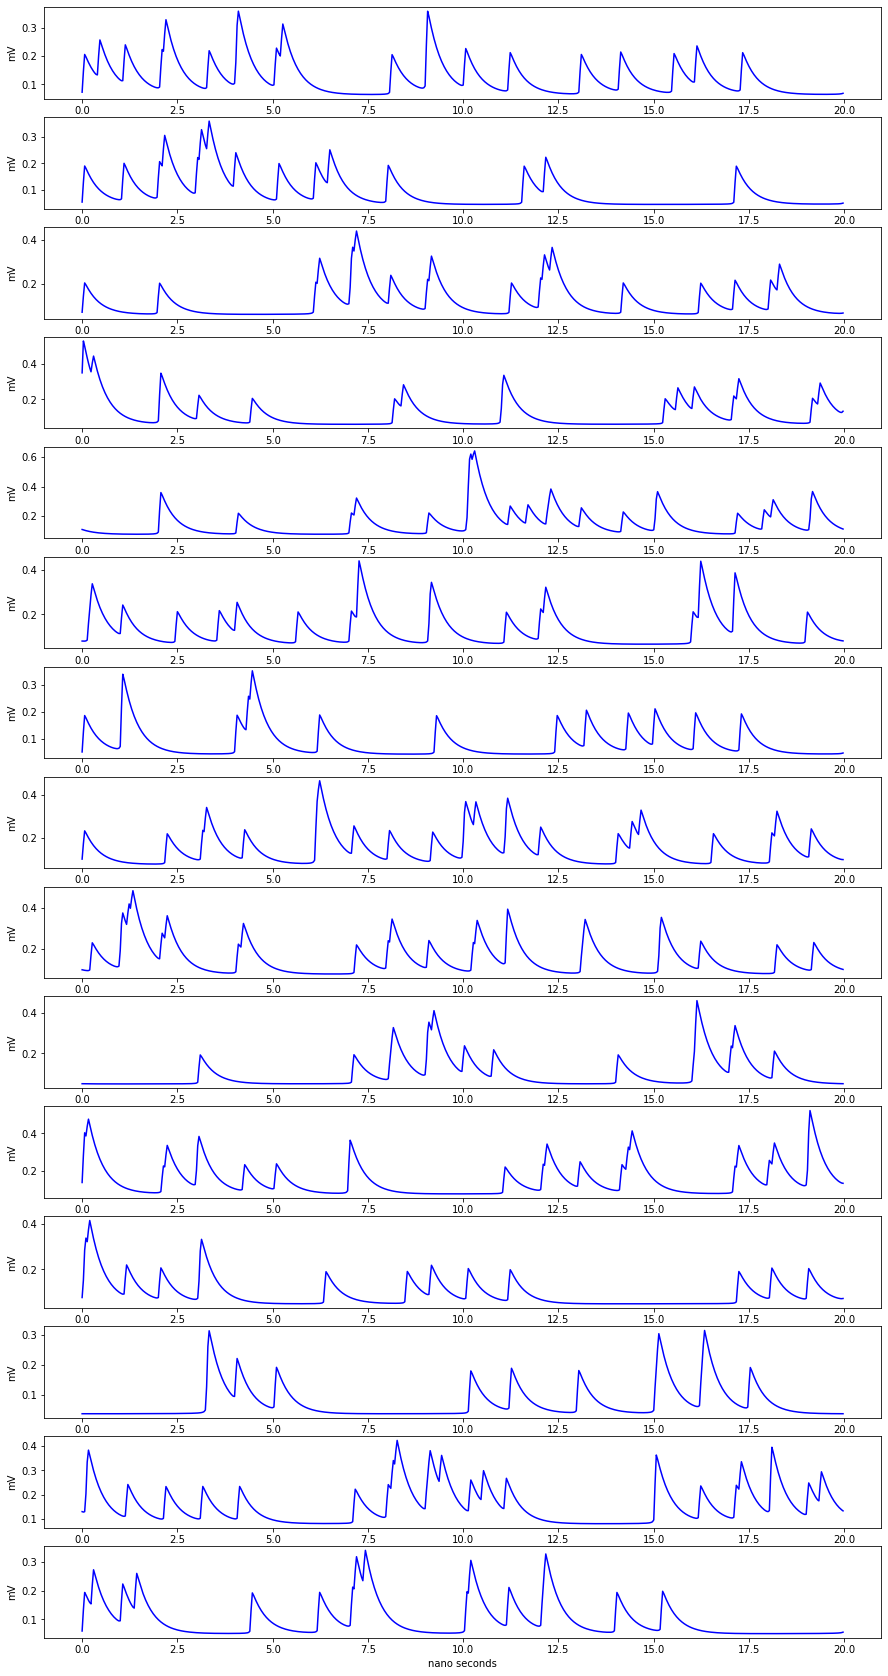

In [39]:
simulation_num = 1
snr_sync = []
snr_unsync = []
sim = simulate_poisson_sequences()
for _ in range(simulation_num):
    sim.run_simulation()
    
fig = plt.figure(figsize=(15,30))
# fig.suptitle("Laser pulses & Possion Current Pulses", fontsize=26)
for i in range(sim.line_number):
    ax = plt.subplot(sim.line_number,1,i+1)
    ax.plot(sim.t_plot,sim.plt_pulse[i],'b')
    ax.plot(sim.t_plot,sim.plt_laser[i],'r')
    ax.set_ylabel("mA")
    
plt.xlabel("nano seconds")
plt.show()

fig = plt.figure(figsize=(15,30))
# fig.suptitle("Transimpedenance Amplifier - High Cut-Off Frequency", fontsize=26)
for i in range(sim.line_number):
    ax = plt.subplot(sim.line_number,1,i+1)
    ax.plot(sim.t_plot,sim.plt_highbw_transimpndance[i],'b')
    ax.set_ylabel("mV")
plt.xlabel("nano seconds")
plt.show()



In [40]:
len(sim.plt_peaks)

15

In [41]:
simulation_num = 5
snr_sync = []
snr_unsync = []
sim = simulate_poisson_sequences()

sim.run_simulation()


In [42]:
np.mean(sim.snr_sync),np.mean(sim.snr_unsync)

(0.82445418518248, 0.872228191836659)

In [43]:
len(sim.t_plot)

600

(599,)
[(313.88149264922515, 0)]


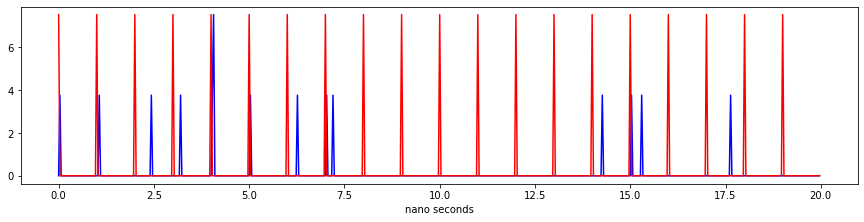

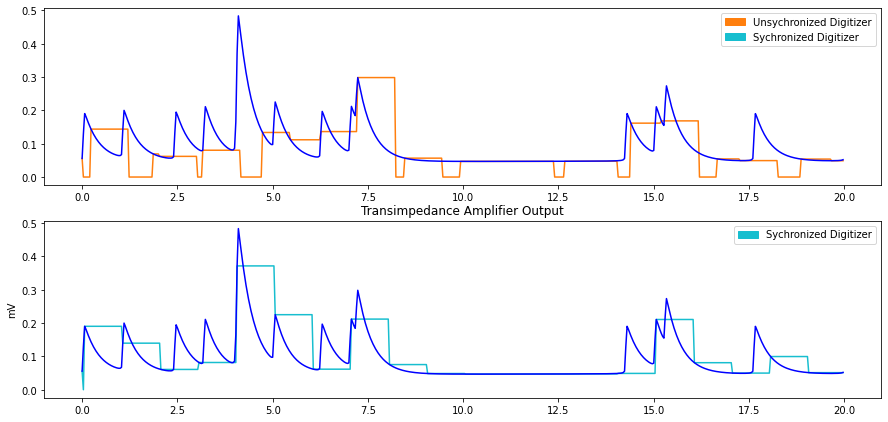

In [44]:


shifts = []
avg_cc = []
# fig.suptitle("Laser pulses & Possion Current Pulses", fontsize=26)
N = len(sim.t_plot)-1
half =  round(N/2+0.5,0)
freq= np.fft.fftfreq(N)
g = np.concatenate([np.arange(0,half),np.arange(half,N)-N])
for i in range(sim.line_number):

    cross = np.fft.fft(sim.plt_pulse[i][:-1])*np.conjugate(np.fft.fft(sim.plt_highbw_transimpndance[i][1:]))
    cc = np.absolute(np.fft.ifft(cross))
    avg_cc.append(cc)
    
    half =  round(N/2+0.5,0)
    shift = [(val,int(i)) for i,val in zip(g,cc.flatten()) if val==np.max(cc.flatten())]
#     print(shift)
    

avg_cc = np.array(avg_cc)
print(freq.shape[:])

avg_cc = np.sum(avg_cc,axis=0)


half =  round(N/2+0.5,0)

shift = [(val,int(i)) for i,val in zip(g,avg_cc.flatten()) if val==np.max(avg_cc.flatten())]
print(shift)
shifts.append(shift[0][1])
    
np.mean(shifts)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(4,1,1)
ax.plot(sim.t_plot[:15000],sim.plt_pulse[0][:15000],'b')
ax.plot(sim.t_plot[:15000],sim.plt_laser[0][:15000],'r')
plt.xlabel("nano seconds")
plt.show()

fig = plt.figure(figsize=(15,15))
red_patch = mpatches.Patch(color='tab:orange', label='Unsychronized Digitizer')
green_patch = mpatches.Patch(color='tab:cyan', label='Sychronized Digitizer')
plt.xlabel("nano seconds")
for i in range(1):
    ax = plt.subplot(4,1,1)
    red_patch = mpatches.Patch(color='tab:orange', label='Unsychronized Digitizer')
    plt.legend(handles=[red_patch,green_patch])
    ax.plot(sim.t_plot[:15000],sim.plt_unsync_digitizer[i][:15000],'tab:orange')
    ax.plot(sim.t_plot[:15000],sim.plt_highbw_transimpndance[i][:15000],'b')



for i in range(1):
    ax = plt.subplot(4,1,2)
    green_patch = mpatches.Patch(color='tab:cyan', label='Sychronized Digitizer')
    plt.legend(handles=[green_patch])
    ax.plot(sim.t_plot[:15000],sim.plt_sync_digitizer[i][:15000],'tab:cyan')
    ax.plot(sim.t_plot[:15000],sim.plt_highbw_transimpndance[i][:15000],'b')
    ax.set_title("Transimpedance Amplifier Output")
    ax.set_ylabel("mV")

    
plt.show()


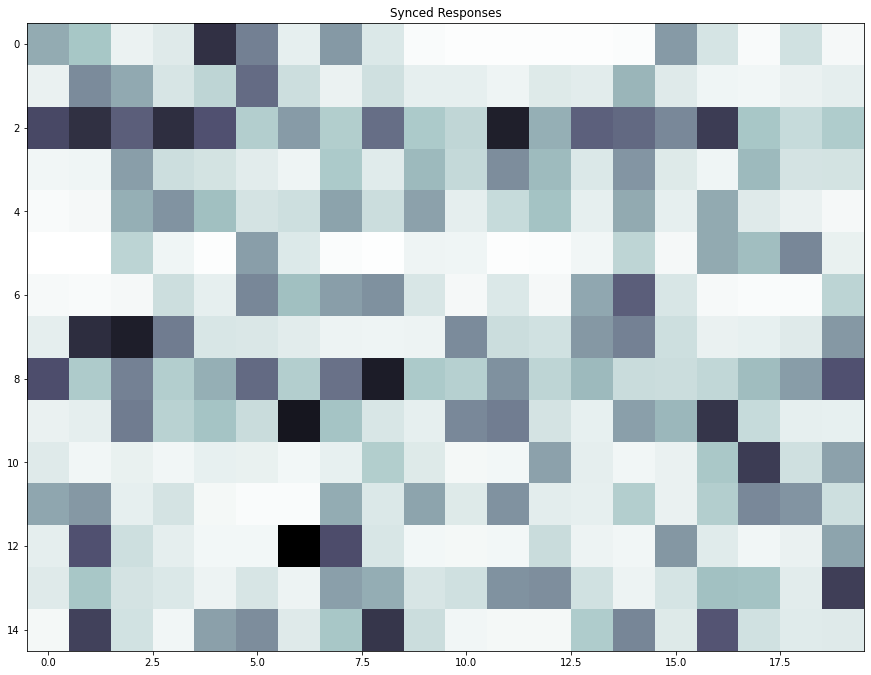

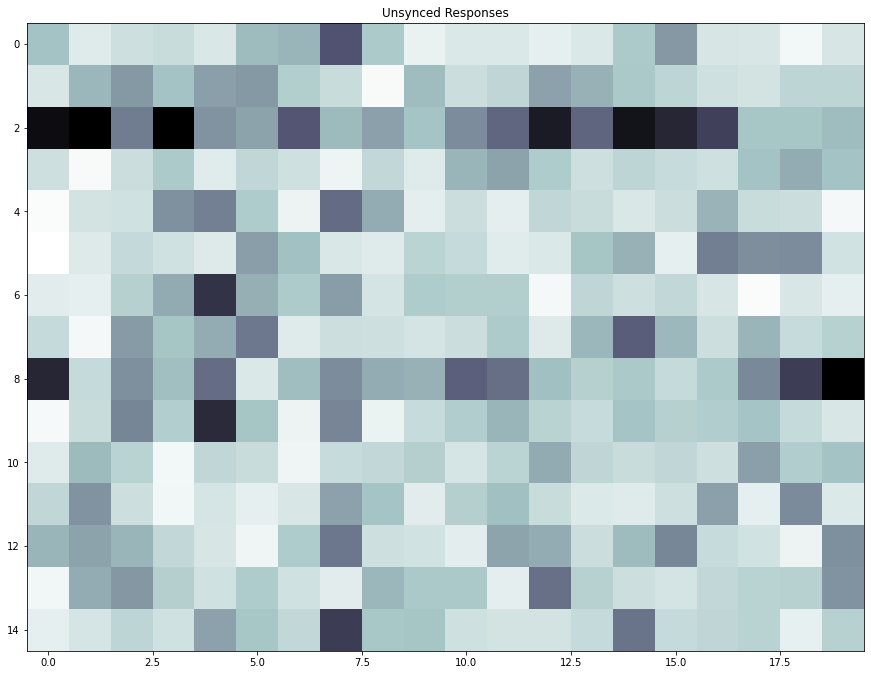

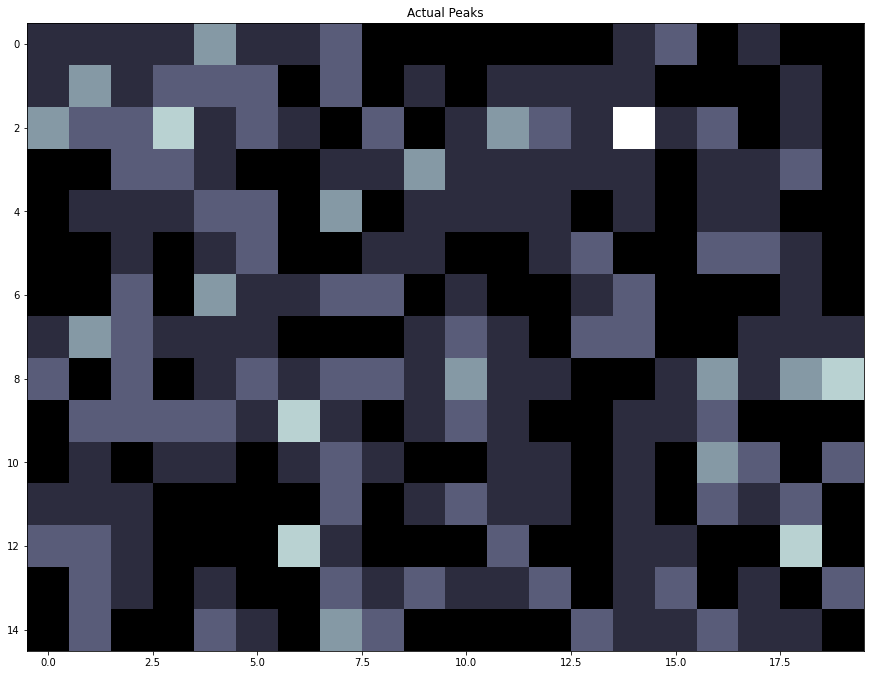

mean error:  0.6846440129449838 variance of errors:  15.506081345765127 sum of squared error:  4792.445631067962
mean error:  3.0787960257159557 variance of errors:  16.404600204310142 sum of squared error:  5206.997954412624
SNR:  0.82445418518248


In [52]:
import cv2

x = np.array(sim.plt_sync_digitizer)
x = np.sum(x.reshape(sim.line_number,sim.beam_num,len(sim.t)),axis=2) * -1
x  = (x - np.mean(x))/np.std(x)
synced_responses = x - np.min(x)
# x = cv2.resize(x,(250,250))
ax = plt.figure(figsize=(15,15))
plt.title('Synced Responses')
# ax = plt.subplot(line_number,1,line+1)
plt.imshow(synced_responses,cmap='bone')
plt.show()


x = np.array(sim.plt_unsync_digitizer)
x = np.sum(x.reshape(sim.line_number,sim.beam_num,len(sim.t)),axis=2) * -1
x  = (x - np.mean(x))/np.std(x)
unsynced_responses  = x - np.min(x)
# x = cv2.resize(x,(250,250))
ax = plt.figure(figsize=(15,15))
plt.title('Unsynced Responses')
# ax = plt.subplot(line_number,1,1)
plt.imshow(unsynced_responses,cmap='bone')
plt.show()


x = np.array(sim.plt_peaks)
x = x
# x = (x - np.min(x))/(np.max(x)-np.min(x)) * 255
actual_response = np.sum(x.reshape(sim.line_number,sim.beam_num,len(sim.t)),axis=2)
# x = cv2.resize(x,(250,250))
ax = plt.figure(figsize=(15,15))
plt.title('Actual Peaks')
# ax = plt.subplot(line_number,1,1)
plt.imshow(actual_response,cmap='bone')
plt.show()



n = len(unsynced_responses.flatten())
X = unsynced_responses.astype(np.int16).reshape(n,1)

Y = actual_response.astype(np.int16).flatten()

A=X.T.dot(X)
b=X.T.dot(Y)
z = np.linalg.solve(A,b)
errors = Y-X.dot(z)

SSE = np.sum((Y-X.dot(z))**2)

SST = np.sum((actual_response.astype(np.int16)-np.mean(actual_response.astype(np.int16)))**2)
# z,1-SSE/SST,SSE

print("mean error: ", np.mean(errors), "variance of errors: ", np.var(errors), "sum of squared error: ", SSE)

SNR = np.var(actual_response)/np.var(errors)
SNR

n = len(synced_responses.flatten())
X = synced_responses.astype(np.int16).reshape(n,1)

Y = actual_response.astype(np.int16).flatten()

A=X.T.dot(X)
b=X.T.dot(Y)
z = np.linalg.solve(A,b)

# z = Regression.numpy_simple_regression(X,Y)
# SSE = Regression.numpy_SSE(X,Y,z)

SSE = np.sum((Y-X.dot(z))**2)

SST = np.sum((actual_response.astype(np.int16)-np.mean(actual_response.astype(np.int16)))**2)
errors = Y-X.dot(z)
print("mean error: ", np.mean(abs(errors)), "variance of errors: ", np.var(errors), "sum of squared error: ", SSE)
# z,1-SSE/SST,SSE

SNR = np.var(actual_response)/np.var(errors)
print('SNR: ',SNR)